In [11]:
import gym_trader.envs.trader as make
import gym

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import deque

### Load the environment

In [12]:
env = make.TraderEnv()
env.seed(0)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Discrete(1)
action space: Discrete(3)


### Policy based method

In [23]:
class Policy():
    def __init__(self, s_size=1, a_size=3):
        self.w = 1e-4*np.random.rand(a_size, s_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w) 
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        
        #action = np.random.choice(3, p=probs.ravel()) # option 1: stochastic policy
        action = np.argmax(probs)                    # option 2: deterministic policy
        return action

In [24]:
policy = Policy()

def trading(episodes=1000, gamma=0.6, print_every=100, noise_scale=1e-3):
    
    scores_deque = deque()
    scores = []
    best_R = -np.Inf
    best_w = policy.w 
   
    for episode in range(1, episodes+1):
        state = env.reset()
        rewards = []
        done = False
        
        while not done:            
            action = policy.act(state)
            state, reward, done, _ = env.step(action)   
            rewards.append(reward)
            #print('action', action, 'state', state, 'reward', reward, 'volume', _['volume'], 'balance', _['balance'], done )
            if done:
                break 
                
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            best_R = R
            best_w = policy.w
            noise_scale = max(1e-3, noise_scale / 2)
            policy.w += noise_scale * np.random.rand(*policy.w.shape) 
        else: # did not find better weights
            noise_scale = min(2, noise_scale * 2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)

        if episode % print_every == 0:
            print('Interval {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))

        if np.mean(scores_deque)>=100.0:
            print('Target Achieved! in {:d} intervals!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))
            policy.w = best_w
            break
               
    return scores
            
scores = trading()

Interval 100	Average Score: -7.84
Interval 200	Average Score: -3.92
Interval 300	Average Score: -2.61
Interval 400	Average Score: -16.59
Interval 500	Average Score: -13.53
Interval 600	Average Score: -11.28
Interval 700	Average Score: -9.67
Interval 800	Average Score: -8.46
Interval 900	Average Score: -7.52
Interval 1000	Average Score: -6.77


### Plot the scores

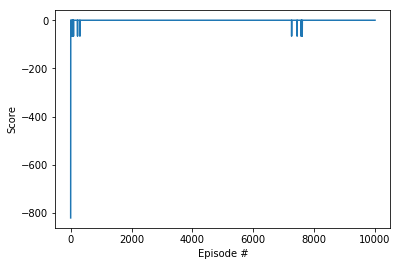

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()